<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/R_th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.style.use('fast')
plt.rc('font', size = 14, family ='Sans-Serif')
 
# download updated data
# repository italy https://github.com/pcm-dpc/COVID-19/tree/master/dati-andamento-nazionale
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url_csv_file)
# DATI COVID REGIONI
# istat http://dati.istat.it/Index.aspx?QueryId=26428#
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
dr = pd.read_csv(url_csv_file)
Lombardia = dr.loc[(dr['denominazione_regione'] == 'Lombardia')].sort_values(by="data").copy()
Lazio = dr.loc[(dr['denominazione_regione'] == 'Lazio')].sort_values(by="data").copy()

# DATI Popolazione Regioni
url_csv_file = "https://docs.google.com/spreadsheet/ccc?key=1qL5B_J6eV6bD9zicR0YsCIaUMU0BhTdSTrqC1UcDBI8&output=csv"
# agiunta terapie intensive https://www.quotidianosanita.it/studi-e-analisi/articolo.php?articolo_id=82888
dpr = pd.read_csv(url_csv_file)
dpr

print('aggiornamento al '+str(np.array(df['data'])[-1])[0:10])
def Exp(x, p0, p1): # negative exponential
    import numpy as np
    return p0*np.exp(x/p1)
 
def Infected(t, I0, mu, R0): # negative exponential
    import numpy as np
# https://medium.com/data-for-science/epidemic-modeling-101-or-why-your-covid19-exponential-fits-are-wrong-97aa50c55f8
    return I0*np.exp(mu*(R0-1)*t)
 
# def Logistic(x, L, k, x0):
#     import numpy as np
#     return L / (1. + np.exp(-k * (x - x0)))
 
def Logistic(x, a, b, c):
    import numpy as np
# https://it.wikipedia.org/wiki/Equazione_logistica
    return a / (1. + b * np.exp(-c * x))
 
def Logistic4(x, a, b, c, d):
    import numpy as np
# https://it.wikipedia.org/wiki/Equazione_logistica
    return a / (1. + b * np.exp(-c * x)) + d
 
def dLogistic(x, a, b, c):
    import numpy as np
    return a*b*c*np.exp(c*x)/(b+np.exp(c*x))**2
 
def Gompertz(x, a, b, c):
    import numpy as np
# https://en.wikipedia.org/wiki/Gompertz_function
    return a * np.exp(-b * np.exp(-c * x))
 
def dGompertz(x, a, b, c):
  import numpy as np
# https://en.wikipedia.org/wiki/Gompertz_function
  return a*b*c * np.exp(-b * np.exp(-c * x))*np.exp(-c * x)
 
def Gauss3(x, a0, x0, s0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))
 
def Line(x, m, q):
    import numpy as np
    return m*x + q
 
def ManSdtSubArr(arr, rescaled_avarege):
  import numpy as np
  if len(arr)>rescaled_avarege & rescaled_avarege>1:
    a_split     = np.array_split(arr, int(len(arr)/rescaled_avarege))
    a_split_avg = [np.mean(x) for x in a_split]
    a_split_err = [np.std(x) for x in a_split]
    return np.array(a_split_avg), np.array(a_split_err)
  else:
    return np.array(arr), np.sqrt(arr)
def fittalo(func, x, y, ax, p0, fmt='k'):
  from scipy.optimize import curve_fit
  from sklearn.metrics import r2_score
  popt, pcov = curve_fit(func,x, y, p0=p0)
  perr = np.sqrt(np.diag(pcov))
  r2=r2_score(y, func(x, *popt))
  xf = np.linspace(x.min(), x.max(), 100)
  ax.plot(xf, func(xf, *popt), fmt, label='a = {0:.2e}±{1:.2e}\nb = {2:.2e}±{3:.2e} \
  \nc = {4:.2e}±{5:.2e}\nr^2 = {6:.3f}'.format(popt[0], perr[0], popt[1], perr[1], popt[2], perr[2], r2))
  return ax, popt

def Rth(data, N=7, d=4):
  # https://www.facebook.com/DatiAnalisiCoronavirus/posts/142436764043174?__tn__=K-R
  # faq ISS https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt
  N=7
  y = np.convolve(data, np.ones((N,))/N, mode='valid')
  x = np.linspace(0, len(y), len(y))
  d=4 
  return x[d:] , y[d:]/y[:-d]

aggiornamento al 2020-11-09


In [41]:
dr.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
0,2020-02-24T18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,NaN,NaN,0,5,NaN,NaN
1,2020-02-24T18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,NaN,NaN
2,2020-02-24T18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,NaN,NaN,0,1,NaN,NaN
3,2020-02-24T18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,NaN,NaN,0,10,NaN,NaN
4,2020-02-24T18:00:00,ITA,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,18,0,18,0,0,NaN,NaN,18,148,NaN,NaN


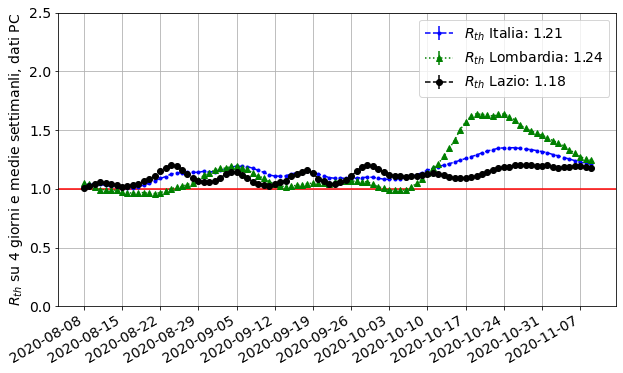

In [16]:
fig, ax = plt.subplots(figsize=(10,6))

what = 'nuovi_positivi'
what = 'ricoverati_con_sintomi' # faq ISS https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt
data = df[what]

xd , y = Rth(data)

cut = len(df)-100
x = np.array(df.iloc[cut+6:,0])
for i in range(len(x)):
  x[i]=x[i][0:10]
ax.errorbar(x , y[xd>cut], yerr=0, fmt='b.--', label='$R_{th}$'+' Italia: {0:.2f}'.format(y[-1]))
data = Lombardia[what]
xd , y = Rth(data)
ax.errorbar(x, y[xd>cut], yerr=0, fmt='g^:', label='$R_{th}$'+' Lombardia: {0:.2f}'.format(y[-1]))
data = Lazio[what]
xd , y = Rth(data)
ax.errorbar(x , y[xd>cut], yerr=0, fmt='ko--', label='$R_{th}$'+' Lazio: {0:.2f}'.format(y[-1]))

ax.axhline(1, color='red')
#ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel(r'$R_{th}$ su 4 giorni e medie settimanli, dati PC')
ax.xaxis.set_major_locator(MultipleLocator(7))

ax.set_ylim(0,2.5)
fig.autofmt_xdate()
ax.legend()
ax.grid()
plt.show()

Max 38 3940
Max 269 2782
Max 37 743
Max 275 518


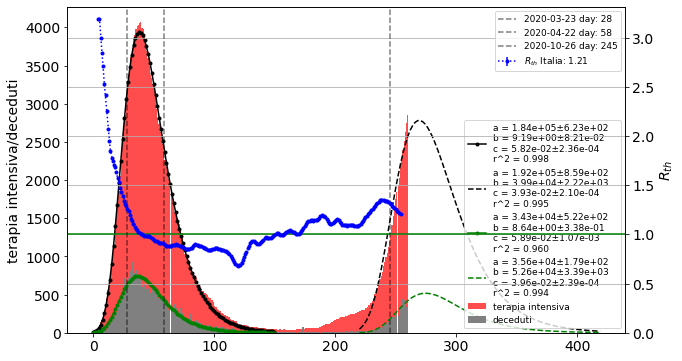

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(0, len(df['data']), len(df['data']))

y = df['terapia_intensiva']
ax.bar(x,y, color='red', alpha=0.7, label='terapia intensiva', width=1)
ax, par = fittalo(dGompertz, x[x<150], y[x<150], ax, [1e5,9., 0.1], 'k.-')
print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))

# Gompertz
# a is the asymptote limit of grow
# b sets the displacement along the x-axis 
# c sets the growth rate (y scaling)
c = par[2]*.7
a = par[0]
b = np.exp(271.*c)
P_start = 220
# fittalo(dGompertz, x[x>220], y[x>220], ax, [a,b,c], 'k--')
xp = np.linspace(P_start, P_start+199, 200)
#ax.plot(xp, dGompertz(xp,*[a,b,c]), 'k')
yp = dGompertz(xp,*[a,b,c])
for i in range(P_start, len(x)):
  yp[i-P_start]=y[i]

ax, par = fittalo(dGompertz, xp, yp, ax, [a,b,c], 'k--')
print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))


# fittalo(Gauss3, x[(x>10) & (x<50)], y[(x>10) & (x<50)], ax, [4000,30, 10], 'r')
# ax.plot(x[x>210], Gauss3(x[x>210],*[5e3,270, 15]), 'k')
# ax.plot(xp, Gauss3(xp,*[5e3,270, 15]), 'k')
# fittalo(Gauss3, x[x>220], y[x>220], ax, [5e3,270, 15], 'r')

y = np.gradient(df['deceduti'])
ax.bar(x,y, color='gray', alpha=1, label='deceduti', width=1)
ax, par = fittalo(dGompertz, x[x<150], y[x<150], ax, [3e4,8., 0.1], 'g.-')
print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))

c = par[2]*0.7
a = par[0]
b = np.exp(276.*c)

# fittalo(dGompertz, x[x>220], y[x>220], ax, [a,b,c], 'k--')
xp = np.linspace(P_start, P_start+199, 200)
#ax.plot(xp, dGompertz(xp,*[a,b,c]), 'k')
yp = dGompertz(xp,*[a,b,c])
for i in range(P_start, len(x)):
  #print (i-P_start, i, yp[i-P_start],y[i])
  yp[i-P_start]=y[i]

ax, par = fittalo(dGompertz, xp, yp, ax, [a,b,c], 'g--')
print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))


# fittalo(Gauss3, x[x<50], y[x<50], ax, [4000,30, 10], 'k--')

ax.set_ylabel(r'terapia intensiva/deceduti')
ax.set_ylim(bottom=0)
ax.legend(loc=4, prop={'size': 9})
ax = ax.twinx()

# ricoverati_con_sintomi
# nuovi_positivi
data = df['ricoverati_con_sintomi']
# N=7
# y = np.convolve(data, np.ones((N,))/N, mode='valid')
# x = np.linspace(0, len(y), len(y))
# d=5

# y_past = y[:-d]
# x_ = x[d:]
# Rth = y[d:]/y_past

x_ , y_ = Rth(data)

ax.errorbar(x_, y_, yerr=0, fmt='b.:', label='$R_{th}$'+' Italia: {0:.2f}'.format(y_[-1]))
ax.axhline(1, color='green')
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel(r'$R_{th}$')
day=28
ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
day=58
ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
day=245
ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)

ax.legend(loc=1, prop={'size': 9})
ax.set_ylim(bottom=0)
ax.grid()
plt.show()

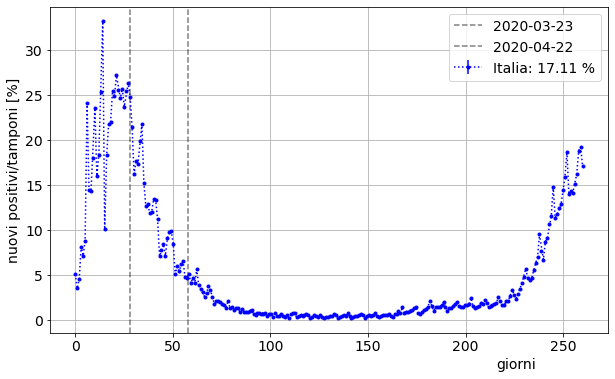

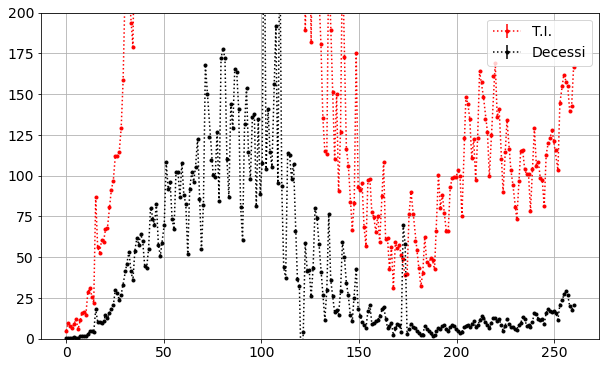

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(0, len(df['data']), len(df['data']))
a = df['nuovi_positivi']
b = np.gradient(df['tamponi'])
y = a/b
err = y*np.sqrt((np.sqrt(a)/a)**2 + (np.sqrt(b)/b)**2)


ax.errorbar(x,y*100, yerr=0, fmt='b:.', label = "Italia: {0:.2f} %".format(y.values[-1]*100))
#GFPlot(y, ax, 4, 'b', label='casi', stat=True)
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel(r'nuovi positivi/tamponi [%]')
day=28
ax.axvline(day, color='black', linestyle='--', label='{:s}'.format(df.iloc[day, 0][0:10]), alpha=0.5)
day=58
ax.axvline(day, color='black', linestyle='--', label='{:s}'.format(df.iloc[day, 0][0:10]), alpha=0.5)
#ax.set_ylim(0,1)
ax.grid()
plt.legend()
plt.show()
fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(x,df['terapia_intensiva']/(y*100), yerr=0, fmt='r:.', label = "T.I.")
ax.errorbar(x,np.gradient(df['deceduti'])/(y*100), yerr=0, fmt='k:.', label = "Decessi")

ax.set_ylim(0,200)
ax.grid()
plt.legend()
plt.show()

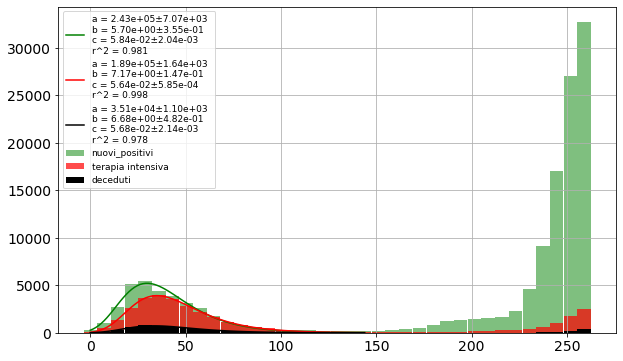

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
average_day = 7
x = np.linspace(0, len(df['data']), len(df['data']))
y = df['totale_positivi']
y, err = ManSdtSubArr(y, average_day)

x = np.linspace(0, len(y)*average_day, len(y))

y = df['nuovi_positivi']
y, err = ManSdtSubArr(y, average_day)
ax.bar(x,y, color='green', alpha=0.5, label='nuovi_positivi', width=average_day) 
fittalo(dGompertz, x[x<150], y[x<150], ax, [4e6,7., 0.1], 'g')
y = df['terapia_intensiva']
y, err =  ManSdtSubArr(y, average_day)
ax.bar(x,y, color='red', alpha=0.7, label='terapia intensiva', width=average_day)
fittalo(dGompertz, x[x<150], y[x<150], ax, [1e5,9., 0.1], 'r')

y = np.gradient(df['deceduti'])
y, err =  ManSdtSubArr(y, average_day)
ax.bar(x,y, color='black', alpha=1, label='deceduti', width=average_day)
fittalo(dGompertz, x[x<150], y[x<150], ax, [3e4,8., 0.1], 'k')

ax.legend(loc=2, prop={'size': 9})
ax.grid()
plt.show()

fitting TI
Max 48 196
Max 268 248
fitting deceduti
Max 53 11
Max 270 23


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in multiply


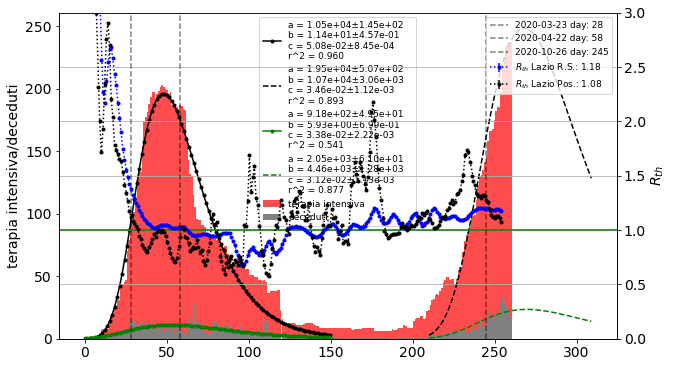

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(0, len(Lazio['data']), len(Lazio['data']))
y = np.array(Lazio['terapia_intensiva'])
ax.bar(x,y, color='red', alpha=0.7, label='terapia intensiva', width=1)
ax, par = fittalo(dGompertz, x[x<150], y[x<150], ax, [1e5,9., 0.1], 'k.-')
print ("fitting TI")
print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))
 
# Gompertz
# a is the asymptote limit of grow
# b sets the displacement along the x-axis 
# c sets the growth rate (y scaling)
c = par[2]*1.2
a = par[0]*1.2
b = np.exp(275.*c)
P_start = 210

xp = np.linspace(P_start, P_start+99, 100)

yp = dGompertz(xp,*[a,b,c])
for i in range(P_start, len(x)):
  yp[i-P_start]=y[i]

ax, par = fittalo(dGompertz, xp, yp, ax, [a,b,c], 'k--')
print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))
 
y = np.gradient(Lazio['deceduti'])
ax.bar(x,y, color='gray', alpha=1, label='deceduti', width=1)
print ("fitting deceduti")
ax, par = fittalo(dGompertz, x[x<150], y[x<150], ax, [3e4,8., 0.1], 'g.-')
print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))
 
c = par[2]
a = par[0]*2
b = np.exp(274.*c)
P_start = 210
 
xp = np.linspace(P_start, P_start+99, 100)

yp = dGompertz(xp,*[a,b,c])
for i in range(P_start, len(x)):
  yp[i-P_start]=y[i]
 
ax, par = fittalo(dGompertz, xp, yp, ax, [a,b,c], 'g--')
print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))
 
 
# fittalo(Gauss3, x[x<50], y[x<50], ax, [4000,30, 10], 'k--')
 
ax.set_ylabel(r'terapia intensiva/deceduti')
ax.set_ylim(bottom=0)
ax.legend(loc=0, prop={'size': 9})
ax = ax.twinx()
 
data = Lazio['ricoverati_con_sintomi']
x_ , y_ = Rth(data)
 
# ax.errorbar(x, y, yerr=0, fmt='k.:', label='running avarege')
ax.errorbar(x_, y_, yerr=0, fmt='b.:', label='$R_{th}$'+' Lazio R.S.: {0:.2f}'.format(y_[-1]))
data = Lazio['nuovi_positivi']
x_ , y_ = Rth(data)
ax.errorbar(x_, y_, yerr=0, fmt='k.:', label='$R_{th}$'+' Lazio Pos.: {0:.2f}'.format(y_[-1]))
ax.axhline(1, color='green')
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel(r'$R_{th}$')
day=28
ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(Lazio.iloc[day, 0][0:10], day), alpha=0.5)
day=58
ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(Lazio.iloc[day, 0][0:10], day), alpha=0.5)
day=245
ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(Lazio.iloc[day, 0][0:10], day), alpha=0.5)
 
ax.legend(loc=1, prop={'size': 9})
ax.set_ylim(bottom=0, top=3)
ax.grid()
plt.show()

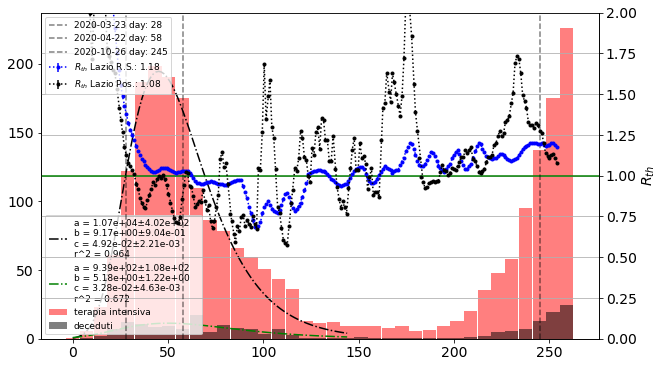

In [21]:
fig, ax = plt.subplots(figsize=(10,6))
average_day = 7

y = Lazio['terapia_intensiva']
y, err =  ManSdtSubArr(y, average_day)
x = np.linspace(0, len(y)*average_day, len(y))
ax.bar(x,y, color='red', alpha=0.5, label='terapia intensiva', width=average_day)
fittalo(dGompertz, x[x<150], y[x<150], ax, [1e5,9., 0.1], 'k-.')

y = np.gradient(Lazio['deceduti'])
y, err =  ManSdtSubArr(y, average_day)
x = np.linspace(0, len(y)*average_day, len(y))
ax.bar(x,y, color='black', alpha=0.5, label='deceduti', width=average_day)
fittalo(dGompertz, x[x<150], y[x<150], ax, [3e4,8., 0.1], 'g-.')

ax.legend(loc=3, prop={'size': 9})
ax = ax.twinx()
 
data = Lazio['ricoverati_con_sintomi']
x_ , y_ = Rth(data)
 
# ax.errorbar(x, y, yerr=0, fmt='k.:', label='running avarege')
ax.errorbar(x_, y_, yerr=0, fmt='b.:', label='$R_{th}$'+' Lazio R.S.: {0:.2f}'.format(y_[-1]))
data = Lazio['nuovi_positivi']
x_ , y_ = Rth(data)
ax.errorbar(x_, y_, yerr=0, fmt='k.:', label='$R_{th}$'+' Lazio Pos.: {0:.2f}'.format(y_[-1]))
ax.axhline(1, color='green')
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel(r'$R_{th}$')
day=28
ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(Lazio.iloc[day, 0][0:10], day), alpha=0.5)
day=58
ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(Lazio.iloc[day, 0][0:10], day), alpha=0.5)
day=245
ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(Lazio.iloc[day, 0][0:10], day), alpha=0.5)
 
ax.legend(loc=2, prop={'size': 9})
ax.set_ylim(bottom=0, top=2)
ax.grid()
plt.show()

Max 37 1342
Max 280 937
Max 33 393
Max 278 274


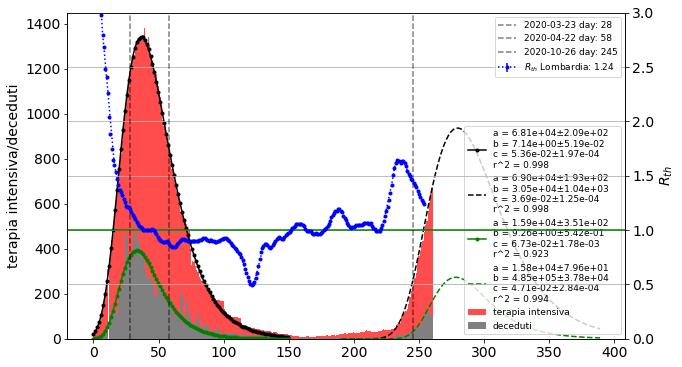

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(0, len(Lombardia['data']), len(Lombardia['data']))
y = np.array(Lombardia['terapia_intensiva'])
ax.bar(x,y, color='red', alpha=0.7, label='terapia intensiva', width=1)
ax, par = fittalo(dGompertz, x[x<150], y[x<150], ax, [1e5,9., 0.1], 'k.-')
print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))
 
# Gompertz
# a is the asymptote limit of grow
# b sets the displacement along the x-axis 
# c sets the growth rate (y scaling)
c = par[2]*.7
a = par[0]
b = np.exp(280.*c)
P_start = 190
# fittalo(dGompertz, x[x>220], y[x>220], ax, [a,b,c], 'k--')
xp = np.linspace(P_start, P_start+199, 200)
#ax.plot(xp, dGompertz(xp,*[a,b,c]), 'k')
yp = dGompertz(xp,*[a,b,c])
for i in range(P_start, len(x)):
  #print (i-P_start, i, yp[i-P_start],y[i])
  yp[i-P_start]=y[i]
 
ax, par = fittalo(dGompertz, xp, yp, ax, [a,b,c], 'k--')
print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))
 
 
# fittalo(Gauss3, x[(x>10) & (x<50)], y[(x>10) & (x<50)], ax, [4000,30, 10], 'r')
# ax.plot(x[x>210], Gauss3(x[x>210],*[5e3,270, 15]), 'k')
# ax.plot(xp, Gauss3(xp,*[5e3,270, 15]), 'k')
# fittalo(Gauss3, x[x>220], y[x>220], ax, [5e3,270, 15], 'r')
 
y = np.gradient(Lombardia['deceduti'])
ax.bar(x,y, color='gray', alpha=1, label='deceduti', width=1)
ax, par = fittalo(dGompertz, x[x<150], y[x<150], ax, [3e4,8., 0.1], 'g.-')
print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))
 
c = par[2]*.7
a = par[0]
b = np.exp(278.*c)
 
# fittalo(dGompertz, x[x>220], y[x>220], ax, [a,b,c], 'k--')
xp = np.linspace(P_start, P_start+199, 200)
#ax.plot(xp, dGompertz(xp,*[a,b,c]), 'k')
yp = dGompertz(xp,*[a,b,c])
for i in range(P_start, len(x)):
  yp[i-P_start]=y[i]
 
ax, par = fittalo(dGompertz, xp, yp, ax, [a,b,c], 'g--')
print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))
 
 
# fittalo(Gauss3, x[x<50], y[x<50], ax, [4000,30, 10], 'k--')
 
ax.set_ylabel(r'terapia intensiva/deceduti')
ax.set_ylim(bottom=0)
ax.legend(loc=4, prop={'size': 9})
ax = ax.twinx()
 
data = Lombardia['ricoverati_con_sintomi']
x_ , y_ = Rth(data)
 
# ax.errorbar(x, y, yerr=0, fmt='k.:', label='running avarege')
ax.errorbar(x_, y_, yerr=0, fmt='b.:', label='$R_{th}$'+' Lombardia: {0:.2f}'.format(y_[-1]))
ax.axhline(1, color='green')
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel(r'$R_{th}$')
day=28
ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(Lombardia.iloc[day, 0][0:10], day), alpha=0.5)
day=58
ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(Lombardia.iloc[day, 0][0:10], day), alpha=0.5)
day=245
ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(Lombardia.iloc[day, 0][0:10], day), alpha=0.5)
 
ax.legend(loc=1, prop={'size': 9})
ax.set_ylim(bottom=0, top=3)
ax.grid()
plt.show()

Lombardia 260
Lazio 260
Campania 260
Sicilia 260
Veneto 260
Emilia-Romagna 260
Piemonte 260
Puglia 260
Toscana 260
Calabria 260
Sardegna 260
Liguria 260
Marche 260
Abruzzo 260
Friuli Venezia Giulia 260
P.A. Trento 260
Umbria 260
Basilicata 260
Molise 260
Valle d'Aosta 260


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


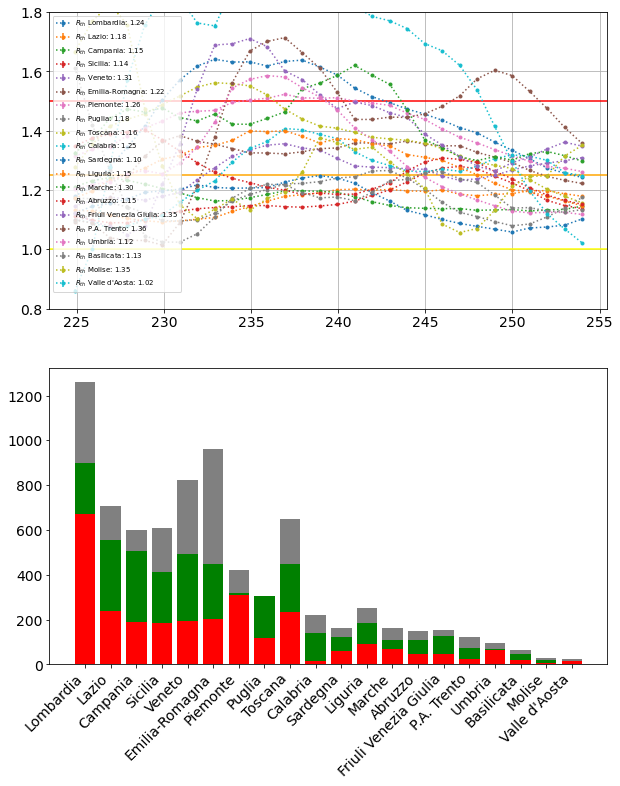

In [77]:
regioni = np.array(dpr['Regione'])
ti = np.array(dpr['terapia_intensiva'])
tie = np.array(dpr['ti_esitenti'])
tir =[]
fig, ax = plt.subplots((2), figsize=(10,12))
for r in range(0, len(regioni)):
  if regioni[r]=='Trentino Alto Adige':
    regioni[r] = 'P.A. Trento'
  drt = dr.loc[(dr['denominazione_regione'] == regioni[r])].sort_values(by="data").copy()
  print(regioni[r], len(drt))
  data = drt['ricoverati_con_sintomi']
  x , y = Rth(data)
  ax[0].errorbar(x[-30:], y[-30:], yerr=0, fmt='.:', label='$R_{th}$'+' {0:s}: {1:.2f}'.format(regioni[r],y[-1]))
  tir.append(np.array(drt['terapia_intensiva'])[-1])
ax[1].bar(regioni, ti, width=0.8, color='gray', align='center')
ax[1].bar(regioni, tie, width=0.8, color='g', align='center')
ax[1].bar(regioni, tir, width=0.8, color='r', align='center')
ax[0].legend(loc=2, prop={'size': 7})
ax[0].set_ylim(bottom=0.8, top=1.8)
ax[0].axhline(1.5, color='red')
ax[0].axhline(1.25, color='orange')
ax[0].axhline(1, color='yellow')
ax[0].grid()
plt.setp(ax[1].get_xticklabels(), rotation=45, ha='right')
plt.show()

In [70]:
tir

[670,
 237,
 191,
 187,
 195,
 204,
 312,
 119,
 234,
 16,
 58,
 92,
 71,
 48,
 46,
 24,
 64,
 18,
 7,
 15]